In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.impute import KNNImputer
import os, gc

pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train_file = '../input/training/training.csv'
test_file = '../input/test/test.csv'
train_data = pd.read_csv(train_file)  
test_data = pd.read_csv(test_file)

## EDA  
1. [ ] Explore imputation strategies
2. [ ] Explore outlier correction strategies
3. [ ] Add noise via rotation, flipped image, blurring, etc.
4. [ ] Update to RMSE

## Explore NA
Based on the below analysis, distributions are fairly normal with some outliers, and mean and median are fairly similar.


Number of columns with any NA value:


True     28
False     3
dtype: int64


Test skew of each distribution:


[('left_eye_center_x', 'Not normal'),
 ('left_eye_center_y', 'Not normal'),
 ('right_eye_center_x', 'Not normal'),
 ('right_eye_center_y', 'Not normal'),
 ('left_eye_inner_corner_x', 'Not normal'),
 ('left_eye_inner_corner_y', 'Not normal'),
 ('left_eye_outer_corner_x', 'Not normal'),
 ('left_eye_outer_corner_y', 'Not normal'),
 ('right_eye_inner_corner_x', 'Not normal'),
 ('right_eye_inner_corner_y', 'Not normal'),
 ('right_eye_outer_corner_x', 'Not normal'),
 ('right_eye_outer_corner_y', 'Not normal'),
 ('left_eyebrow_inner_end_x', 'Not normal'),
 ('left_eyebrow_inner_end_y', 'Not normal'),
 ('left_eyebrow_outer_end_x', 'Not normal'),
 ('left_eyebrow_outer_end_y', 'Not normal'),
 ('right_eyebrow_inner_end_x', 'Not normal'),
 ('right_eyebrow_inner_end_y', 'Not normal'),
 ('right_eyebrow_outer_end_x', 'Not normal'),
 ('right_eyebrow_outer_end_y', 'Not normal'),
 ('mouth_left_corner_x', 'Not normal'),
 ('mouth_left_corner_y', 'Not normal'),
 ('mouth_right_corner_x', 'Normal'),
 ('mouth_

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326


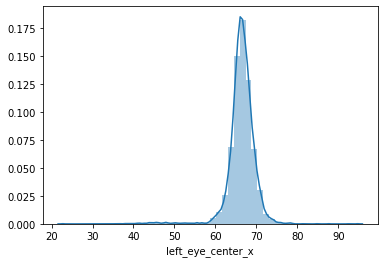

In [36]:
print('\nNumber of columns with any NA value:')
train_data.isnull().any().value_counts()
columns_nan = train_data.columns[train_data.isna().any()].tolist()

print('\nTest skew of each distribution:')
[(col,['Not normal' if stats.skewtest(train_data[col],nan_policy='omit').pvalue < .05 else 'Normal'][0]) for col in columns_nan]

print('\nCompare mean and median of these distribution:')
train_data.describe().loc[['mean','50%']]
sns.distplot(train_data[columns_nan[0]])

Use Nearest Neighbors imputation

In [25]:
y_train = train_data[[col for col in train_data.columns if col != 'Image']].to_numpy()
y_train

In [34]:
imputer = KNNImputer(n_neighbors=3, weights='distance')
tmp = imputer.fit_transform(y_train)
pd.DataFrame(tmp).isnull().any().value_counts()

False    30
dtype: int64